## ZVAR Utilities: Example Notebook

This notebook demonstrates the use of the ZVAR utilities. The utilities are a set of functions that can be used to interact with the ZVAR data products, more specifically the variability candidate datasets, which are a subset of the periodicity data product, limited to "truly" periodic sources. To which we add crossmatch information with other catalogs: Gaia DR3, Pan-STARRS, AllWISE, and 2MASS.


In this notebook, we'll demonstate how to:
- Load the variability candidate dataset
- Based on their Gaia cross-match plot them on a color-magnitude diagram
- Extract sub-sets of the data based on their variability properties
- Retrieve and plot the light curves of a subset of sources, folded by their best period
- Run Schuster & FPW algorithms to find the best period on a source's light curve (*Optional step, as it can be computationally expensive and periods are already provided in the dataset. More of a technical demonstration*)

---

### Imports

First, we need to import zvar_utils. To avoid having to pip install zvar_utils, we can use the following code to import the module from the parent directory (assuming the notebook is in a subdirectory of the zvar_utils directory):

In [21]:
import sys
sys.path.append("..")

from zvar_utils.candidate import import_from_parquet, VariabilityCandidate
from zvar_utils.lightcurves import freq_grid, retrieve_objs_lightcurve
from zvar_utils.plot import plot_gaia_cmd, plot_folded_lightcurve, plot_periodicity
from zvar_utils.files import get_ssh_client
from zvar_utils.stats import median_abs_deviation

*This is very convenient, since you can easily make changes to the zvar_utils module, and re-import it just by restarting the kernel.*

Then, we can import the other "external" modules we'll use in this notebook.

In [2]:
import glob
import numpy as np
from astropy.timeseries import LombScargle

Last but not least, we **optionally** import `fpw`, which while it is pre-compiled, isn't published on pypi yet. If you'd like to use it, just reach out to `tdulaz@caltech.edu` or `swhitebook@astro.caltech.edu`.

*Note: If you don't have the `fpw` module, you can still run the notebook, and simply won't be able to run the last few cells.*

In [3]:
try:
    import fpw # (needs to be installed from a .whl generated by Sam)
except ImportError:
    print("Could not import fpw. You will not be able to use the fpw module.")
    pass

### Data access initialization (local & remote)

Here, we'll set up a few variables to:
- Define the path to where the periodicity candidate datasets are stored **locally**
- Define the path to where the lightcurve data is stored **locally**
- Define the path to where the lightcurve data is stored **on the server** (magnetar, or hypernova)
- Define the hostname, username, and password (or path to ssh key) to access the server

*Notes:*

*- If you don't have access to the server, you can still run the notebooks by not passing the `ssh_client` to the lightcurve retrieval functions. This will limit you to only using the local data.*

*- While you can use a password directly, it is recommended to use an ssh key, as it is more secure. In this notebook, we use an ssh key but this can easily be changed (in the following cell) to use a password.*

In [4]:
path_candidates = '../data/variability_candidates'
path_lc = '../data/zvar/lc'
remote_path_lc = '/data/zvar/matchfiles'

host = 'magnetar.caltech.edu'
username = 'tdulaz'
pkey_path = '/Users/theodlz/.ssh/magnetar'
# or, password = '<your_password>'

ssh_client = get_ssh_client(host, username=username, pkey_path=pkey_path)

Successfully connected to magnetar.caltech.edu


### Variability Candidates

Let's load the variability candidates for a given field & band (here we use field 648, r-band):

In [5]:
band = 'r'
field = '0648'

cand_files = glob.glob(f'{path_candidates}/{field}/*_z{band}.parquet', recursive=True)
candidate_list: list[VariabilityCandidate] = []
for file in cand_files:
    candidate_list.extend(import_from_parquet(file))
            
print(f"Loaded {len(candidate_list)} candidates, from {len(cand_files)} files")

Loaded 1124 candidates, from 1 files


Let's take a quick look at the data, which is a list of `VariabilityCandidate` objects (a class defined in `zvar_utils`).

In [6]:
first_candidate = candidate_list[0]
print(first_candidate)

ID: 143513570184190869, RA: 357.0184326171875, Dec: 29.591903686523438, Valid: 0.9425837397575378, Best M: 5, freq: 9.353532791137695, FAP: 0.000494051469615342
    PS1: G: 20.59±0.03, R: 19.39±0.02, I: 18.46±0.01, Z: 17.93±0.01, Y: 17.72±0.01
    Gaia: G: 19.11, BP: 20.21, RP: 18.08, Parallax: 1.45±0.24, PMRA: 2.99±0.24, PMDEC: -3.02±0.17
    2MASS: J: 16.73±nan, H: 15.78±nan, K: 15.75±nan
    AllWISE: W1: 15.64±0.04, W2: 15.61±0.12, W3: 12.70±nan, W4: 8.98±nan


As you can see, printing the `VariabilityCandidate` class will give you a summary of the object, including his crossmatch information with other catalogs (if available).

However, this is a regular python class so you can also print all of it's attributes and methods with:

In [7]:
# variable and method names (exluding private ones that start with '__')
print([x for x in dir(first_candidate) if not x.startswith('__')])

# you can see that the ps1, gaia, 2mass, and allwise data are their own objects
# Let's look at their types
print(type(first_candidate.ps1))
print(type(first_candidate.gaia))
print(type(first_candidate.twomass))
print(type(first_candidate.allwise))

# and then let's look at their attributes and methods
print([x for x in dir(first_candidate.ps1) if not x.startswith('__')])
print([x for x in dir(first_candidate.gaia) if not x.startswith('__')])
print([x for x in dir(first_candidate.twomass) if not x.startswith('__')])
print([x for x in dir(first_candidate.allwise) if not x.startswith('__')])

['allwise', 'best_M', 'dec', 'fap', 'freq', 'gaia', 'id', 'ps1', 'ra', 'set_2mass', 'set_allwise', 'set_gaia', 'set_ps1', 'twomass', 'valid']
<class 'zvar_utils.candidate.PS1Match'>
<class 'zvar_utils.candidate.GaiaMatch'>
<class 'zvar_utils.candidate.TwoMASSMatch'>
<class 'zvar_utils.candidate.AllWISEMatch'>
['g', 'g_err', 'i', 'i_err', 'id', 'r', 'r_err', 'y', 'y_err', 'z', 'z_err']
['BP', 'BP_RP', 'G', 'MG', 'RP', 'add_MG', 'add_bp_rp', 'id', 'parallax', 'parallax_error', 'pmdec', 'pmdec_error', 'pmra', 'pmra_error']
['h', 'h_err', 'id', 'j', 'j_err', 'k', 'k_err']
['id', 'w1', 'w1_err', 'w2', 'w2_err', 'w3', 'w3_err', 'w4', 'w4_err']


PS1, Gaia, 2MASS, and AllWISE crossmatch information are found as their own python class (as shown in the previous cell). You can also print them which will format the information in a more human-readable way, just like the `VariabilityCandidate` class:

In [8]:
print(first_candidate.ps1)
print(first_candidate.gaia)
print(first_candidate.twomass)
print(first_candidate.allwise)

G: 20.59±0.03, R: 19.39±0.02, I: 18.46±0.01, Z: 17.93±0.01, Y: 17.72±0.01
G: 19.11, BP: 20.21, RP: 18.08, Parallax: 1.45±0.24, PMRA: 2.99±0.24, PMDEC: -3.02±0.17
J: 16.73±nan, H: 15.78±nan, K: 15.75±nan
W1: 15.64±0.04, W2: 15.61±0.12, W3: 12.70±nan, W4: 8.98±nan


Now that we have an idea of what the data looks like, let's create 4 subsets of candidates based on their Gaia data and/or period:
- Red candidates (gaia.BP_RP > 3.0)
- White Dwarf candidates (gaia.BP_RP < 2.0 & gaia.MG > 10.0)
- Giant candidates (gaia.BP_RP > 1.0 & gaia.MG < 3.0)
- Short Period candidates (period < 1 hour)

In [9]:
red_candidates = [
    candidate for candidate in candidate_list
    if candidate.gaia.BP_RP is not None and candidate.gaia.BP_RP > 3.0
]

wd_candidates = [
    candidate for candidate in candidate_list
    if (
        candidate.gaia.BP_RP is not None and candidate.gaia.BP_RP < 2.0
        and candidate.gaia.MG is not None and candidate.gaia.MG > 10.0
    )
]

giant_candidates = [
    candidate for candidate in candidate_list
    if (
        candidate.gaia.BP_RP is not None and candidate.gaia.BP_RP > 1.0
        and candidate.gaia.MG is not None and candidate.gaia.MG < 3.0
    )
]

short_candidates = [
    candidate for candidate in candidate_list
    if 1/candidate.freq < 1/24
]

In the following sections, we'll focus on a subset of these candidates (giants), and plot their light curves. But first, let's see how many candidates we have in each subset:

In [10]:
print(f"Found {len(red_candidates)} red candidates")
print(f"Found {len(wd_candidates)} white dwarf candidates")
print(f"Found {len(giant_candidates)} giant candidates")
print(f"Found {len(short_candidates)} short period candidates")

Found 11 red candidates
Found 9 white dwarf candidates
Found 27 giant candidates
Found 7 short period candidates


### Gaia Color-Magnitude Diagram (CMD)

Now that we have an idea of what the data looks like, let's plot the candidates (that have valid Gaia data) on a color-magnitude diagram (CMD). We'll plot the full dataset first, and then focus on the giants subset.

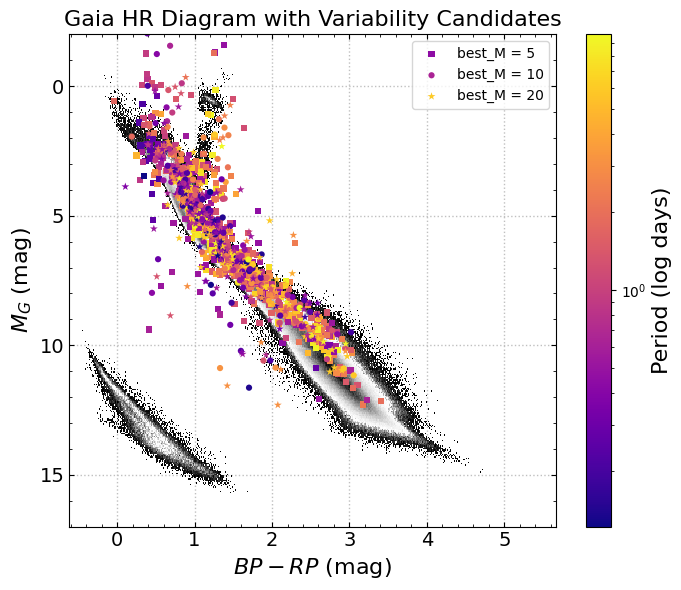

In [22]:
plot_gaia_cmd(candidate_list, figsize=(7,6))

and here is the CMD for the giants subset:

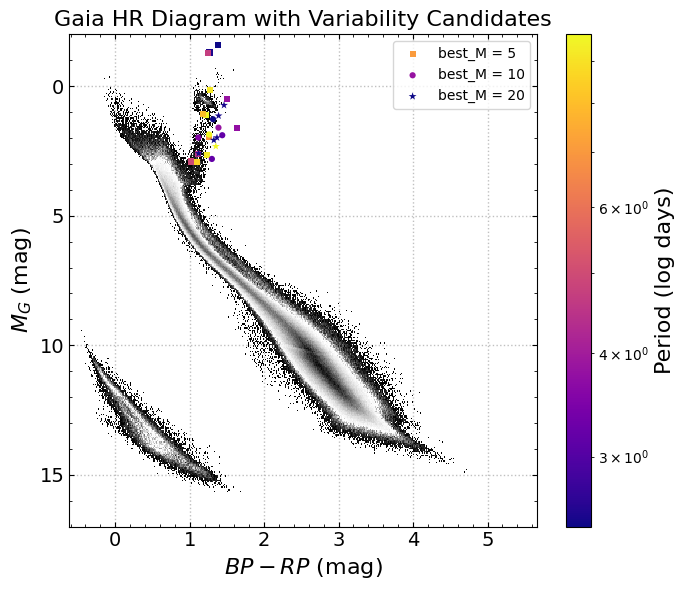

In [12]:
plot_gaia_cmd(giant_candidates, figsize=(7,6))

*Notes:*

*- The Gaia data is not available for all sources, so some sources will not be plotted on the CMD.*

*- The Gaia data in some parts of the sky seems to yield unexpected results (e.g. ZTF field 279), so the CMD may not look as expected in some cases. We suggest looking at the diagram on an entire field before looking at individual subsets, to avoid confusion.*

### Light Curves retrieval and plotting

Now that we have an idea of what the candidates metadata looks like, let's retrieve the light curves for a subset of the candidates. We'll focus on the giants subset, and plot their light curves.

*Notes*:

*- In this section, we'll use the `ssh_client` variable defined earlier, to automagically retrieve the light curves from the server, if not available locally. If you don't have access to the server but already have the light curves locally, you can simply **not** pass the `ssh_client` variable to the function.*

*- You'll notice that we pass the `field` to the `retrieve_objs_lightcurve` function. This is because internally we find the overlapping field(s) based on the candidates positions, and retrieve the light curves for all those fields. If you have overlapping field (such as the primary & secondary grid), this could result in us fetching data from multiple fields. Since we already know what field(s) we are looking at in advance, we can optionally specify*

*- The `retrieve_objs_lightcurve` also optionally takes a `bands` parameter, used to restrict in which filters we want to retrieve the light curves. If not specified, it will retrieve in `g` and `r` bands by default. Here we leave it unspecified, so we can later plot the light curves in both bands.*

In [13]:
# let's plot their lightcurves, folded on the best period, both g an r band
all_photometry = retrieve_objs_lightcurve(
    objs=giant_candidates,
    path_lc=path_lc,
    ssh_client=ssh_client,
    remote_path_lc=remote_path_lc,
    limit_fields=[int(field)] # limit to the field we are interested in
)

Before plotting the light curves, let's take a look at the light curve data we just retrieved. The data is a dictionnary with the candidates' id as keys, and the light curve data as values. The light curve data is simply an array of 4 numpy arrays: `time`, `flux`, `flux_err`, and `filter`, where the `time` is in `BJD` set to 0 at the first observation, the `flux` is in `ADU`, the `flux_err` is in `ADU`, and the `filter` is an integer representing the filter (1 for `g`, 2 for `r`, 3 for `i`). It contains detections and upper limits, and deep-drilling data has been removed already.

In [14]:
first_candidate = giant_candidates[0]
phot = all_photometry[first_candidate.id]

print(phot.shape) # (4, N) where N is the number of data points

# you can access the time, flux, flux_err, and filter by index
time, flux, flux_err, filter = phot[0], phot[1], phot[2], phot[3]

# or simply destructure the array which is more readable
time, flux, flux_err, filter = phot

(4, 1081)


Now that we know what the light curve data looks like, let's plot the light curves for the giants subset. We'll plot the light curves in both `g` and `r` bands, and fold each light curve by the best period found in the variability candidate dataset.

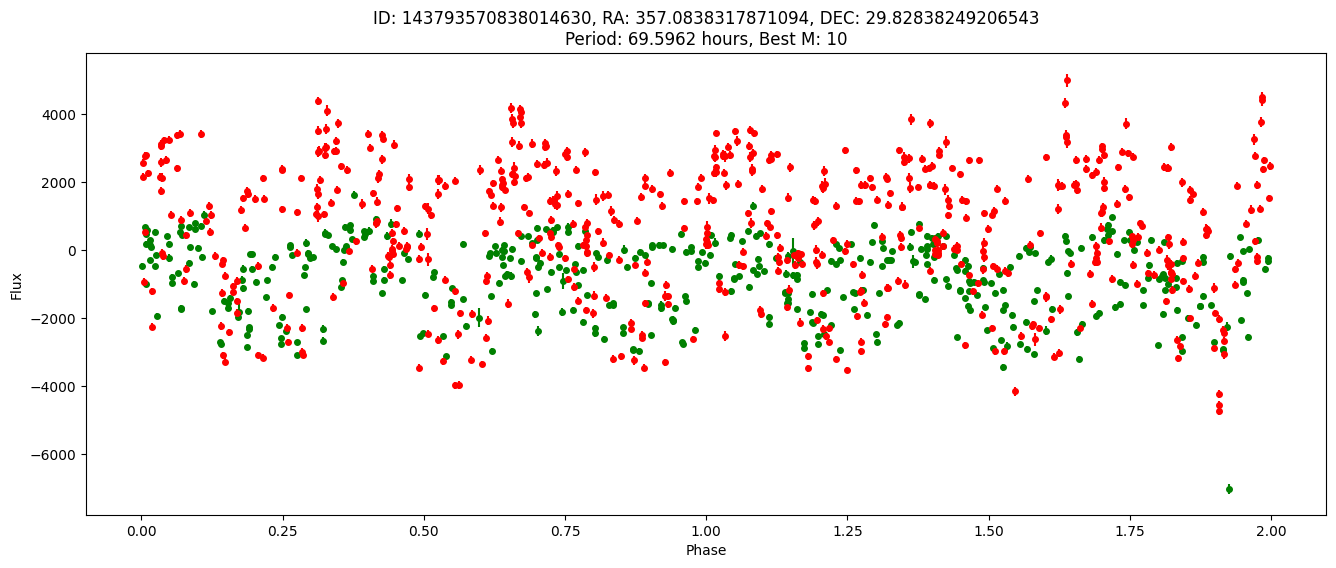

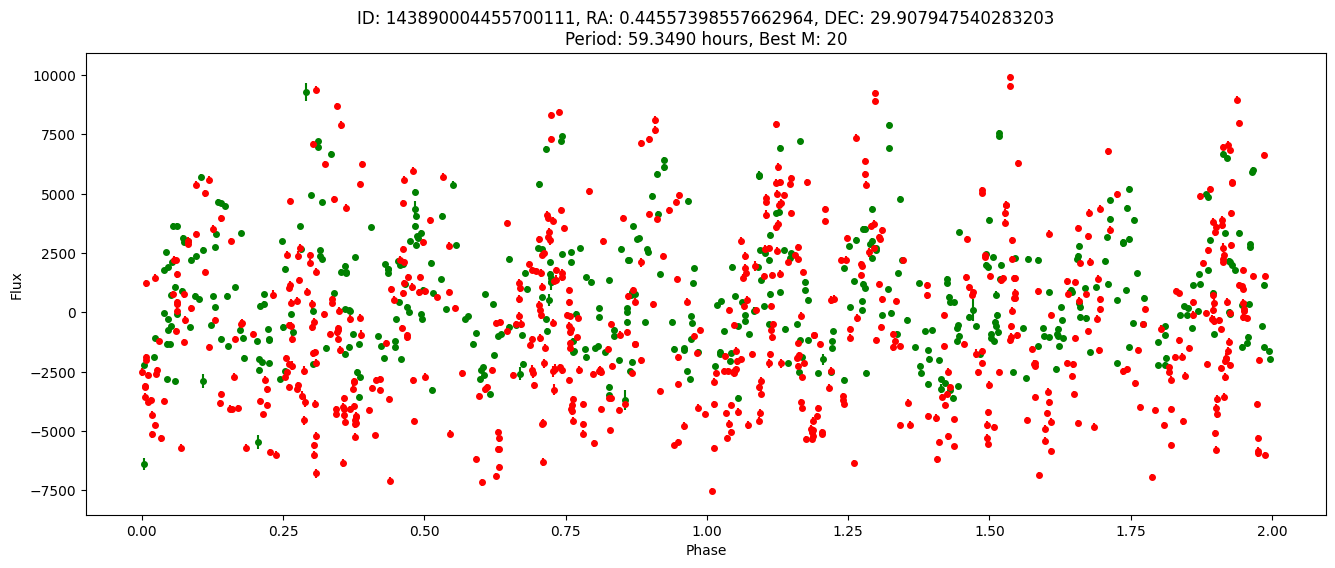

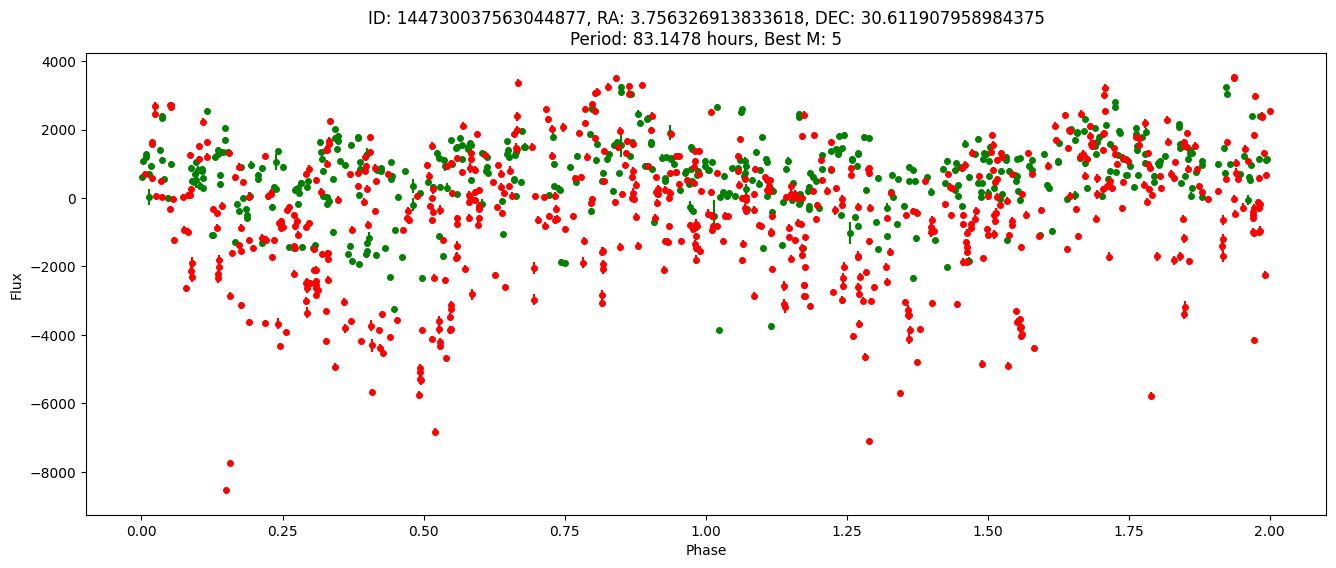

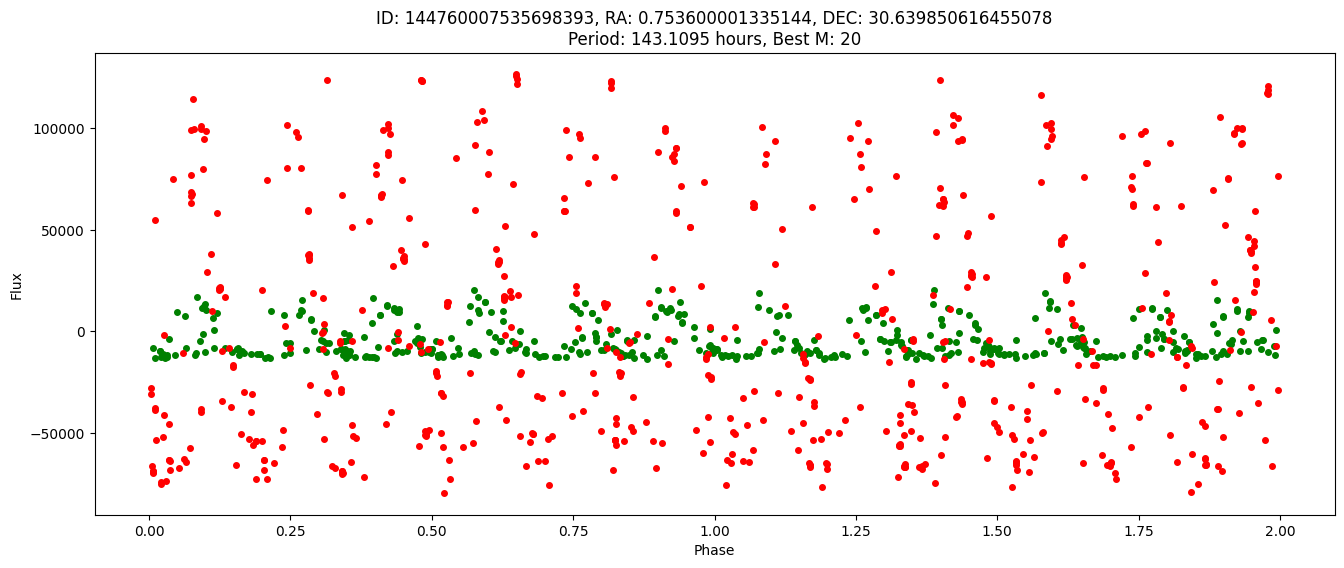

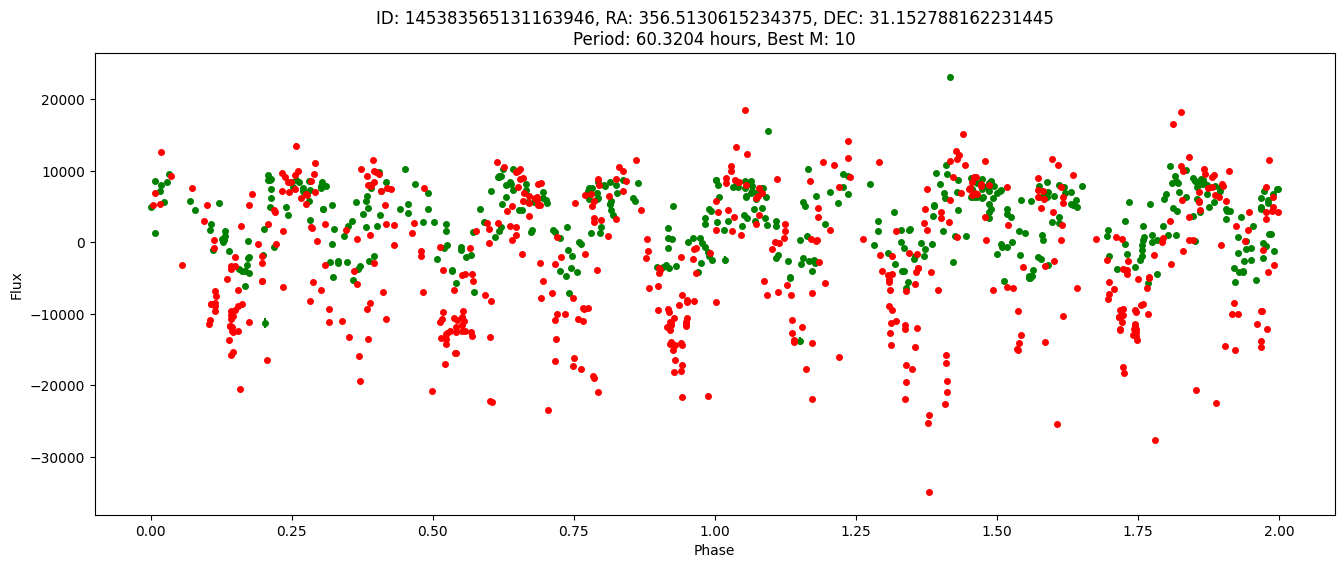

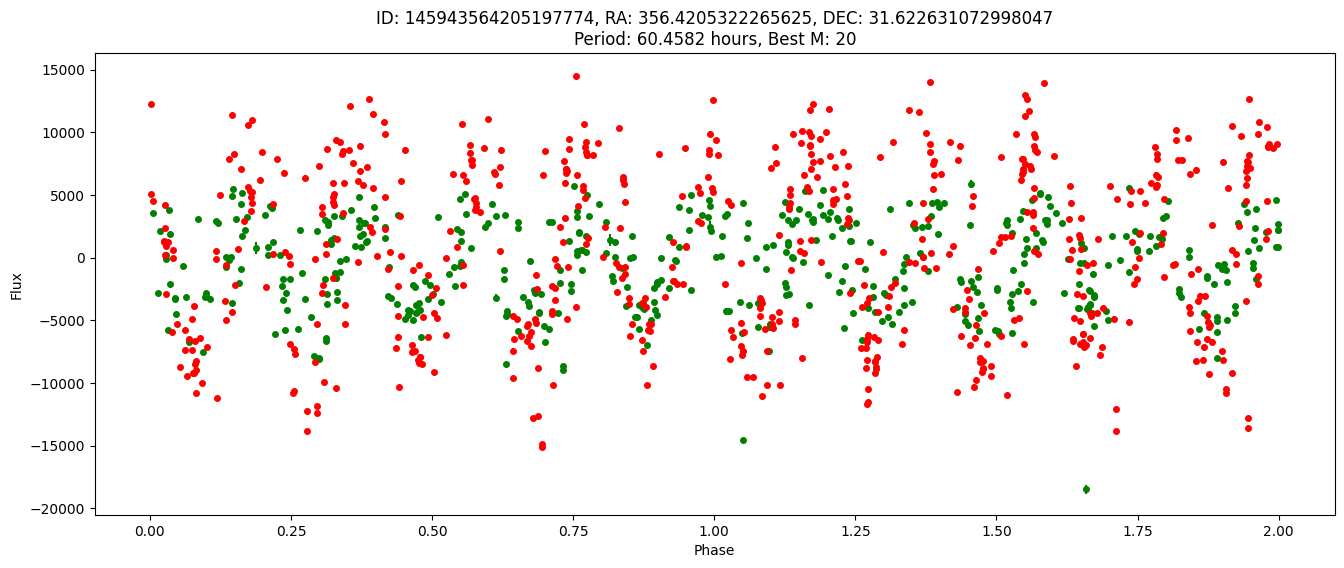

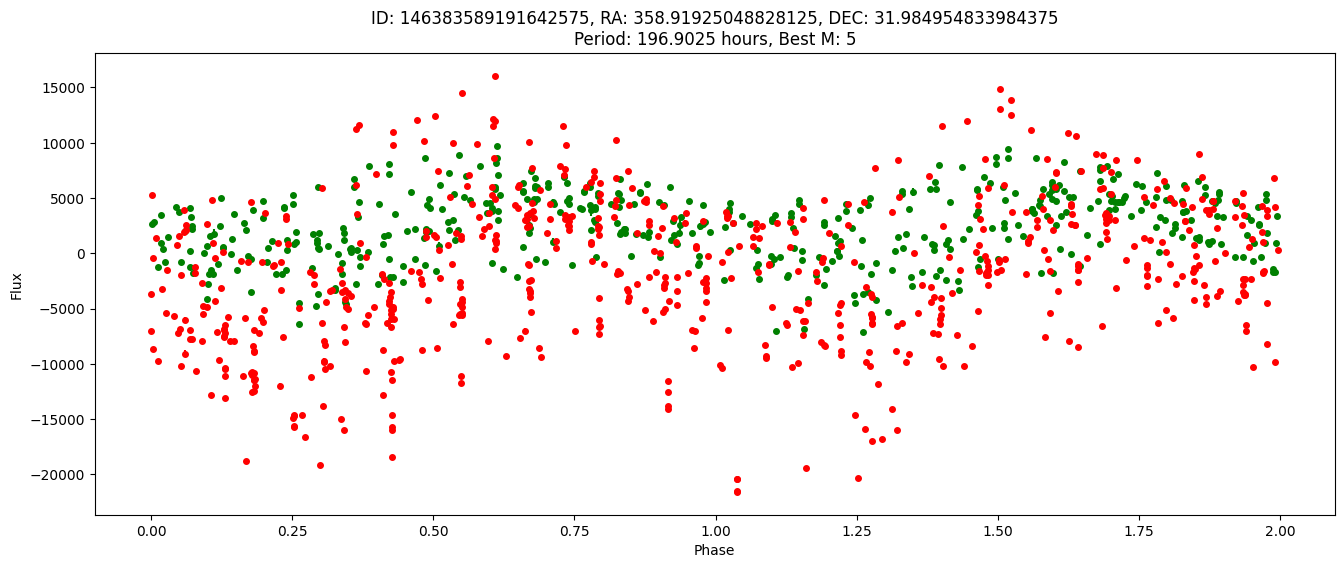

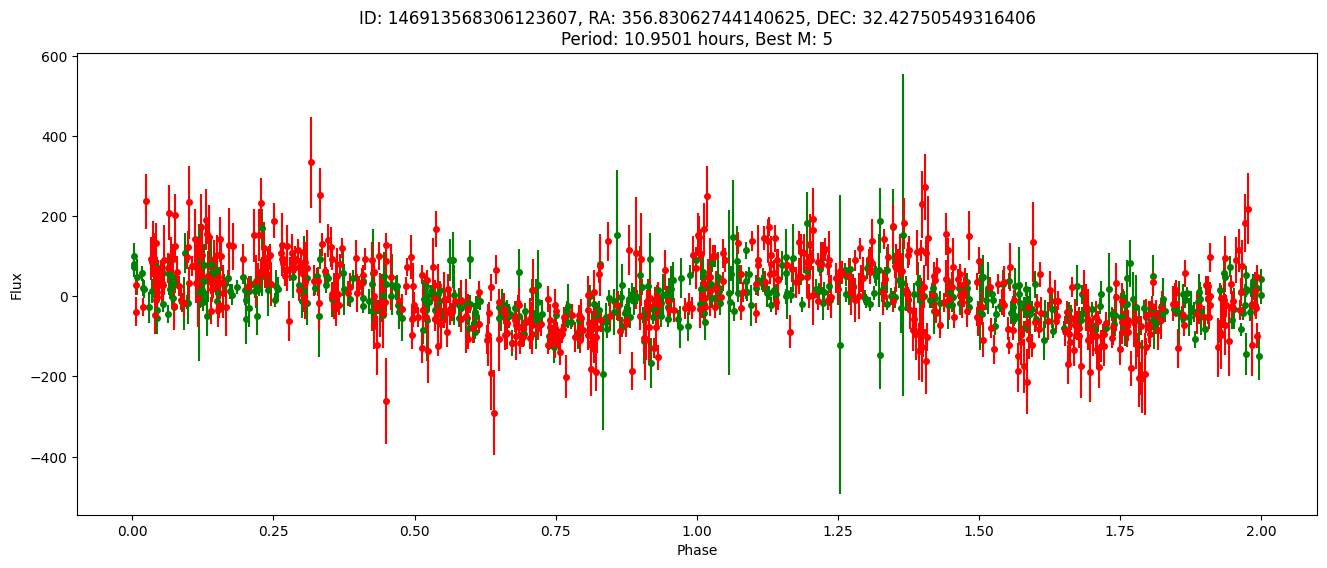

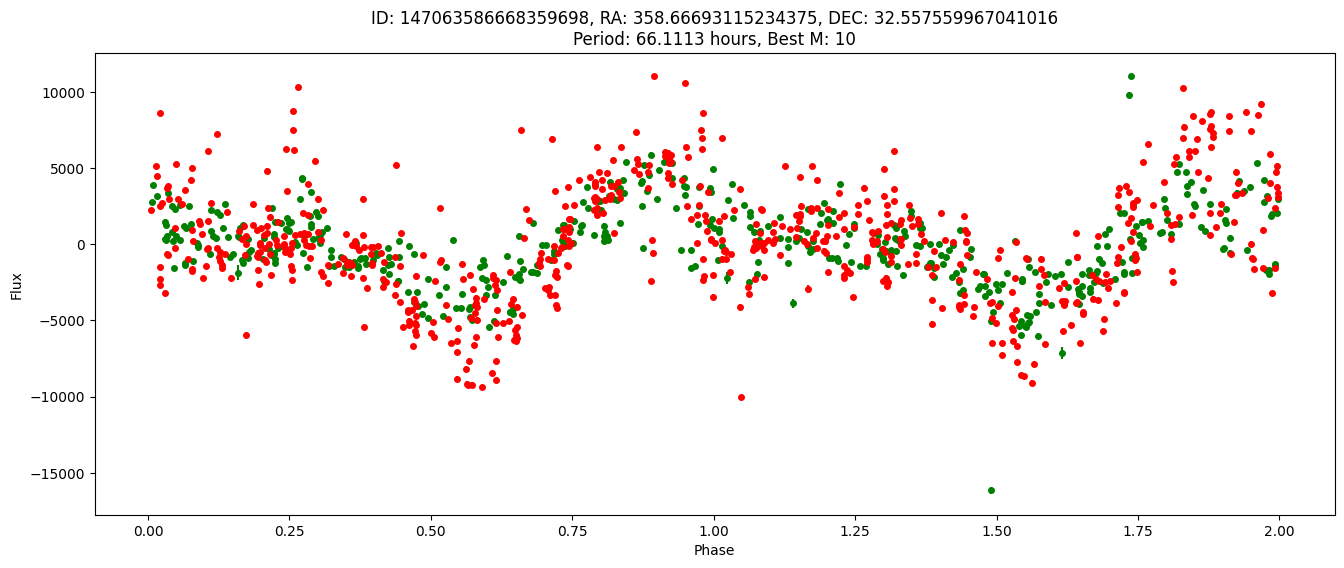

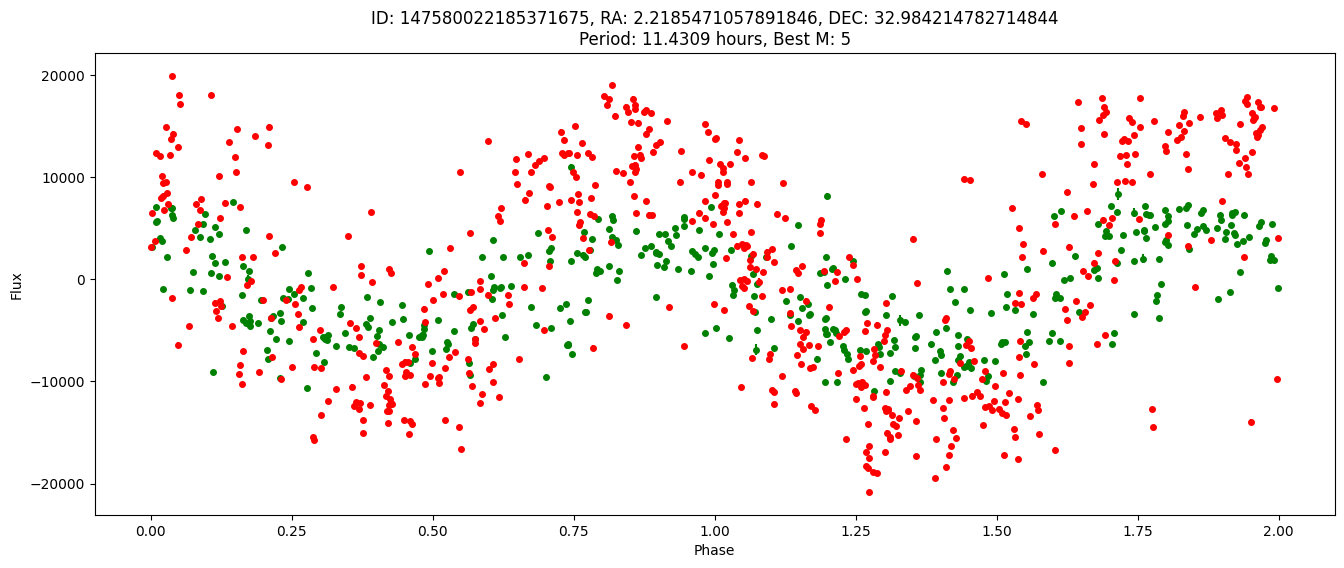

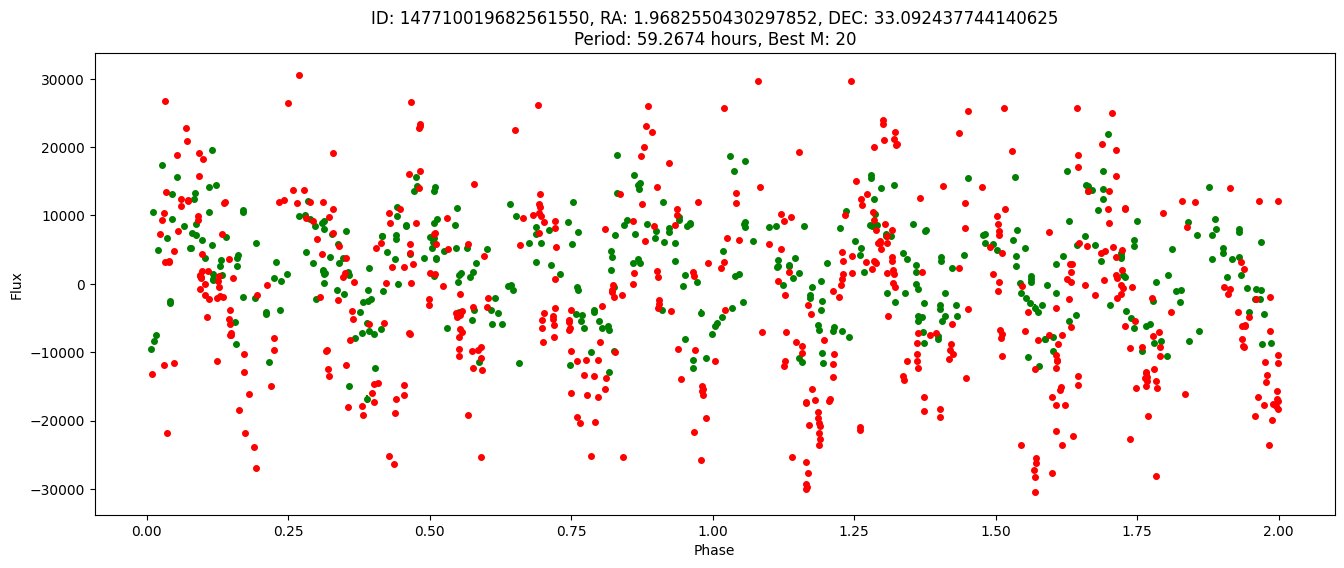

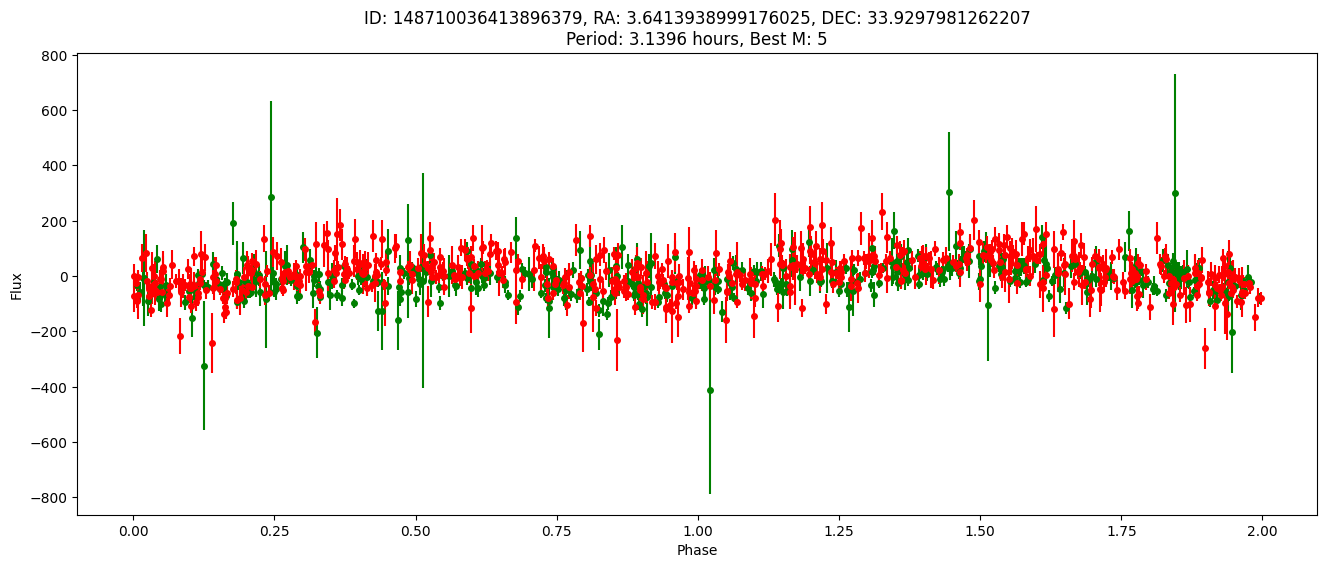

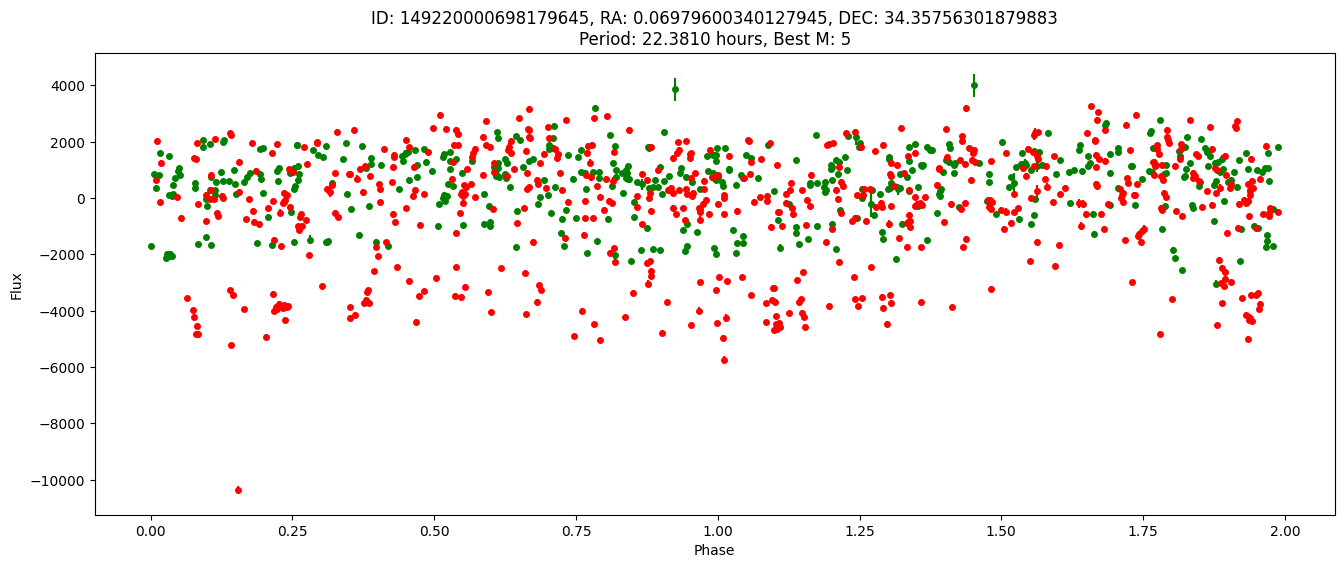

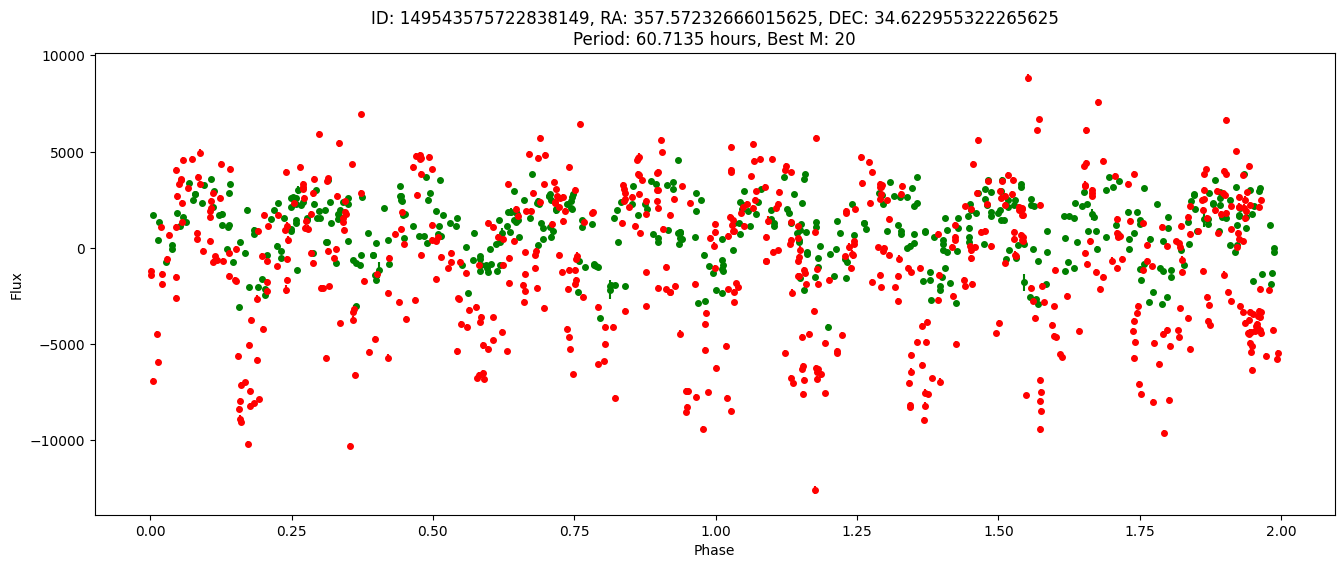

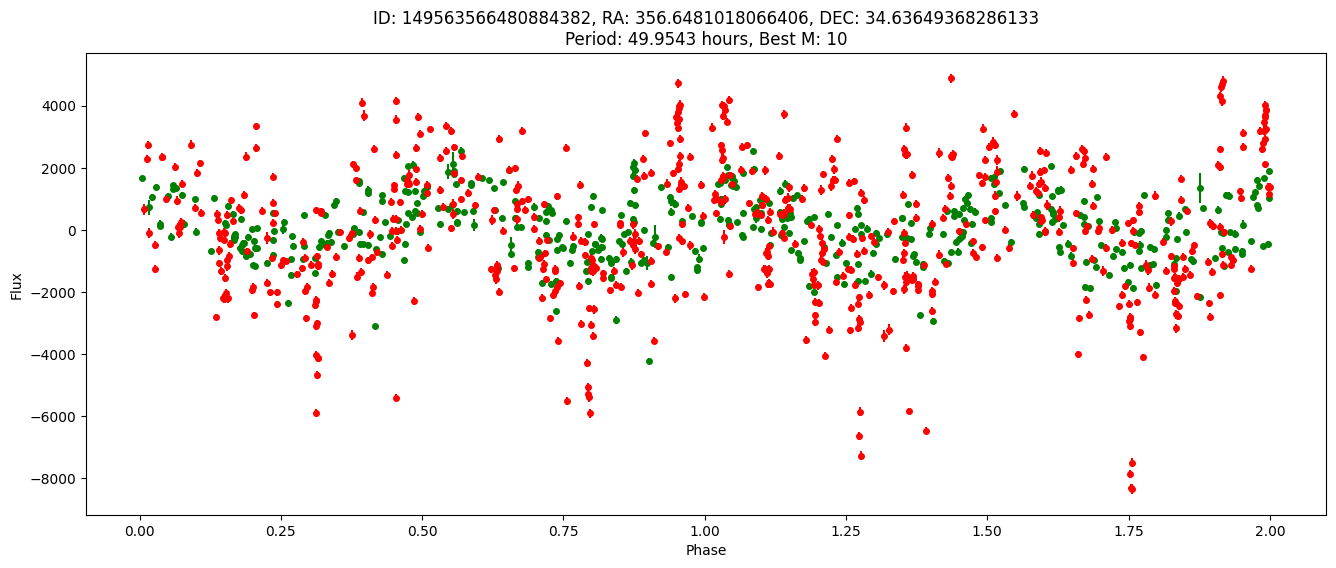

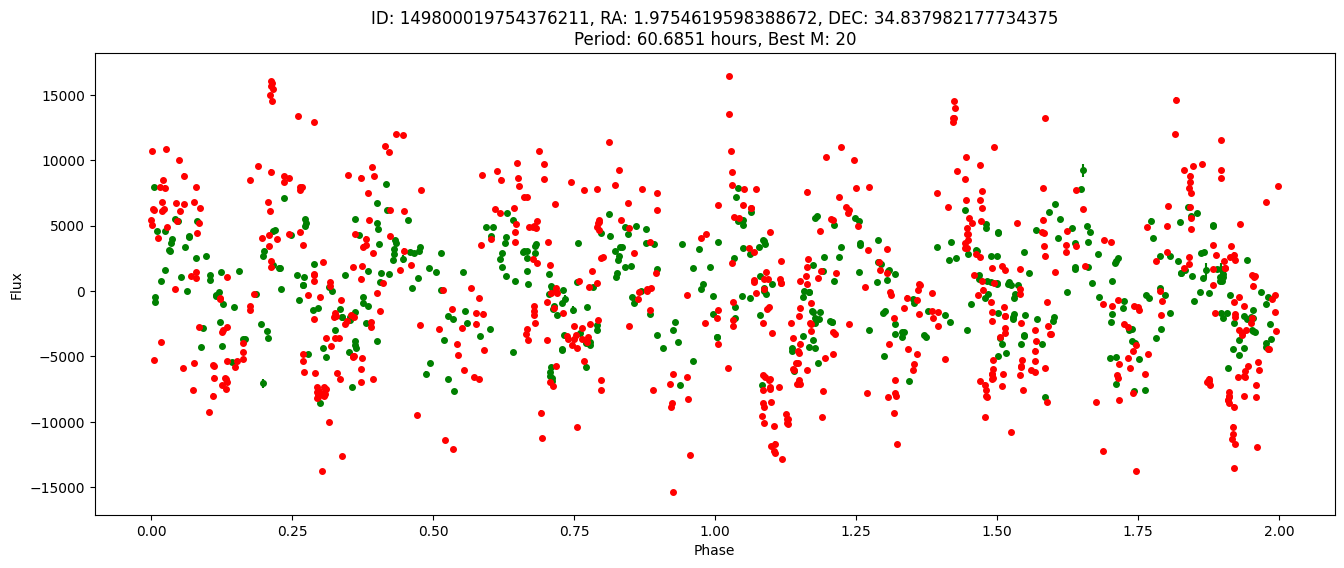

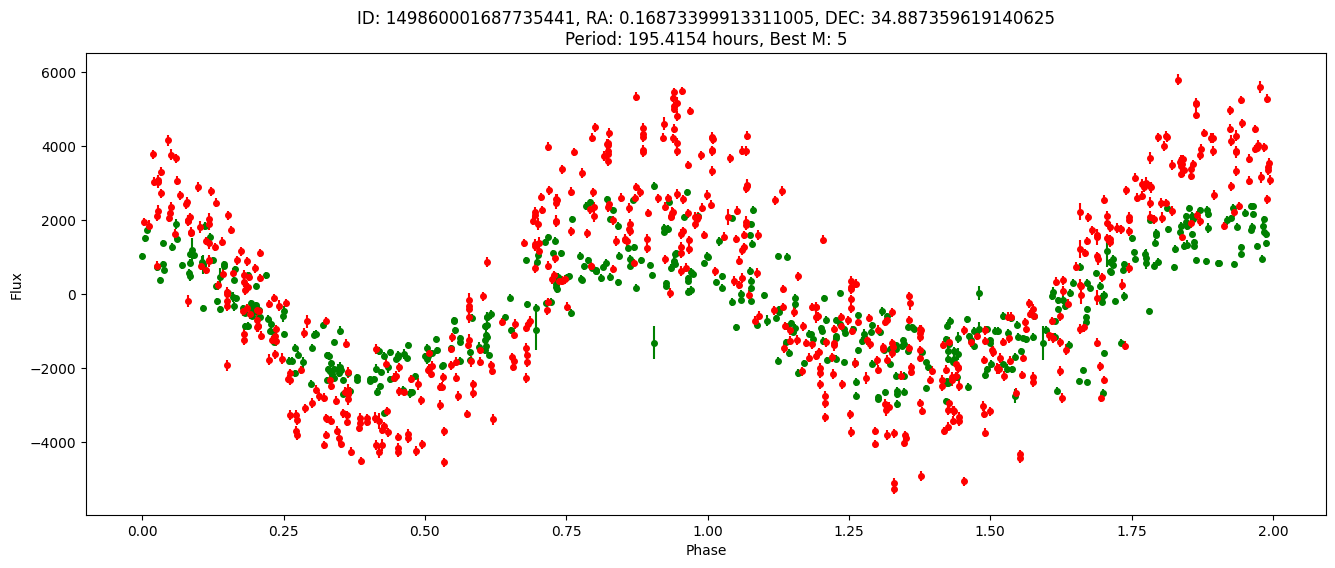

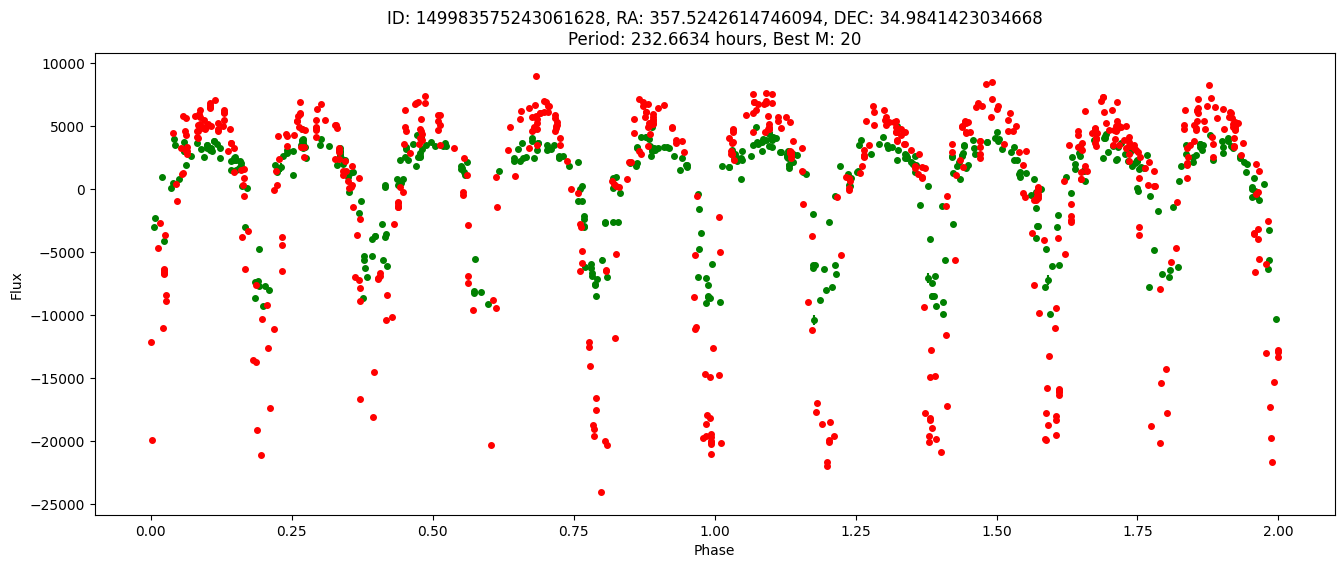

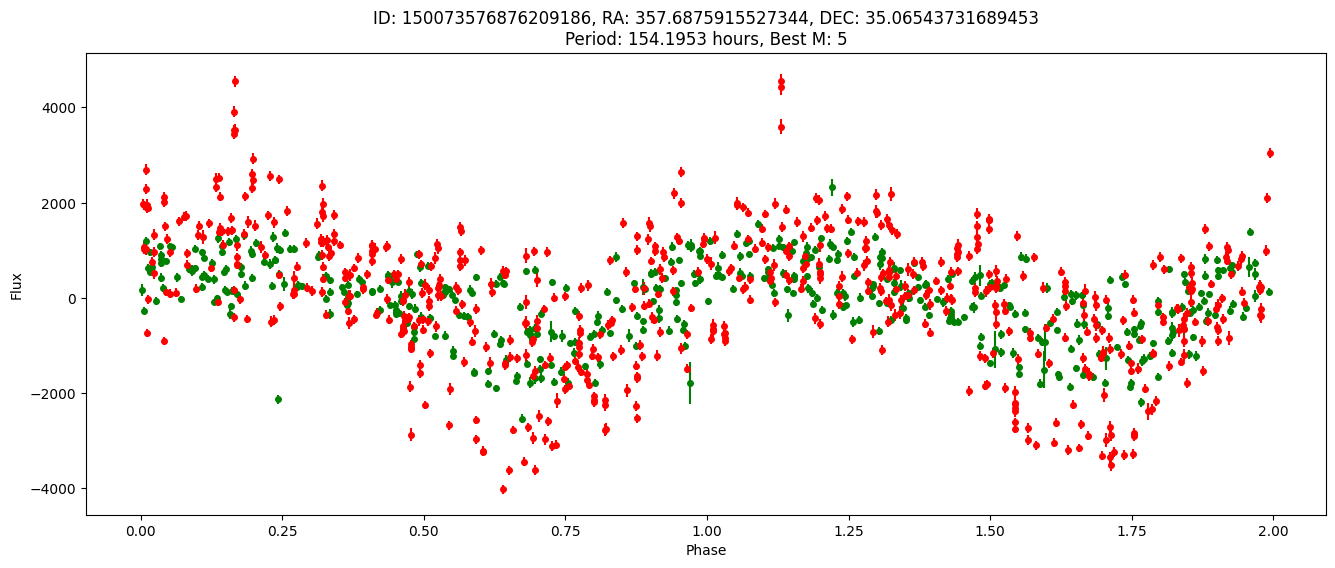

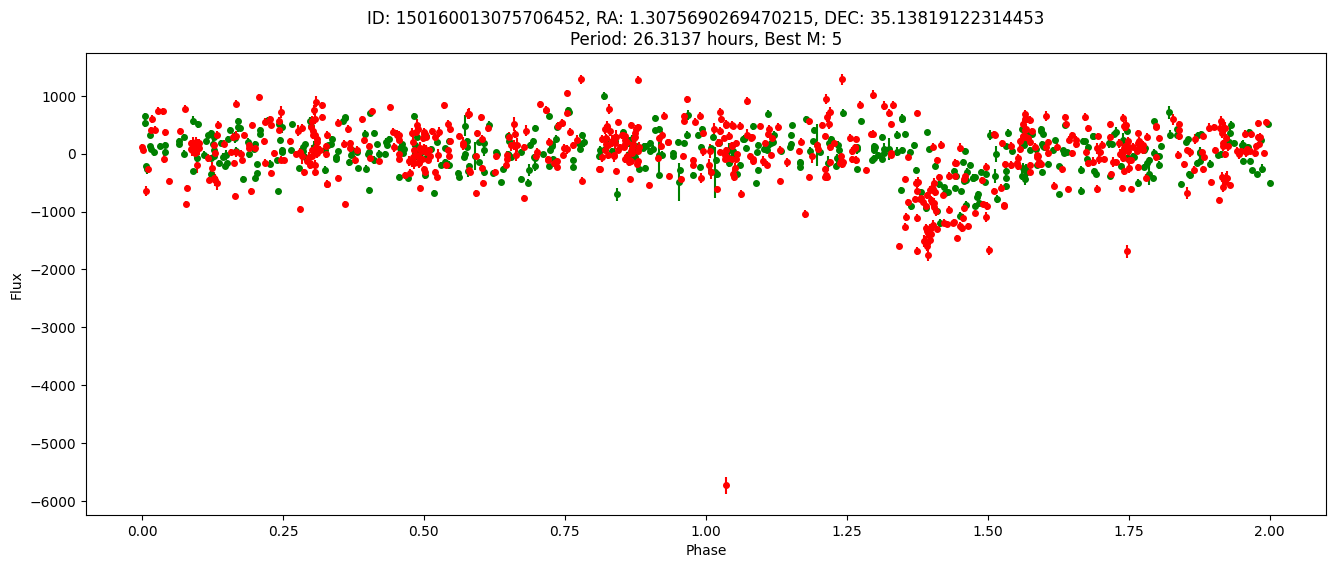

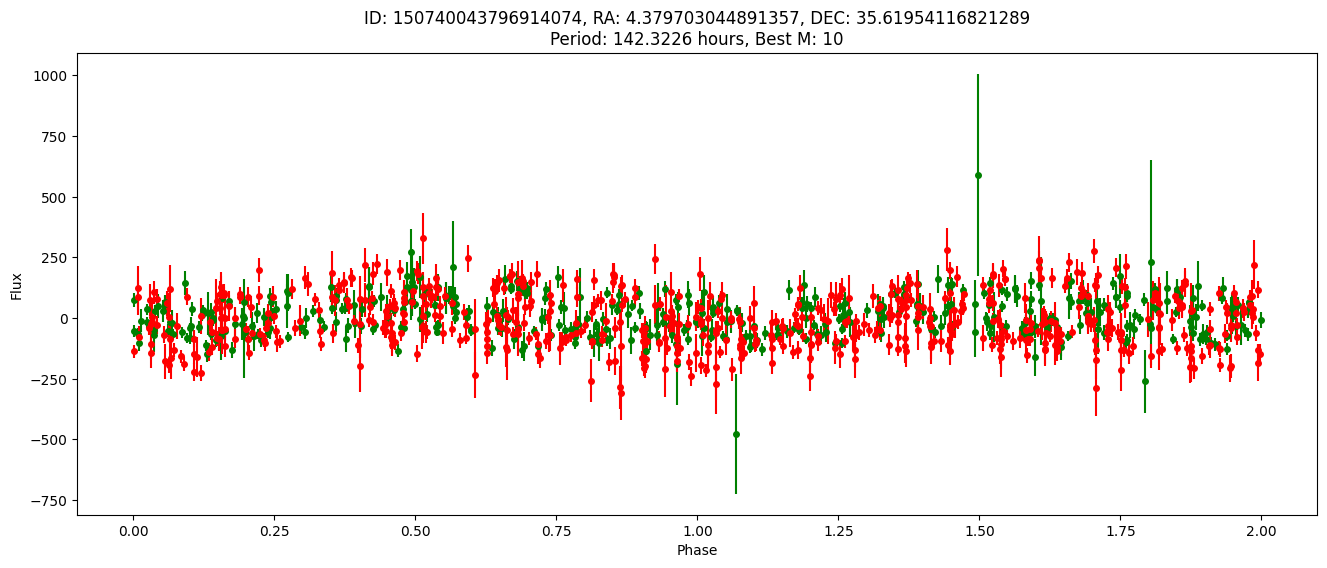

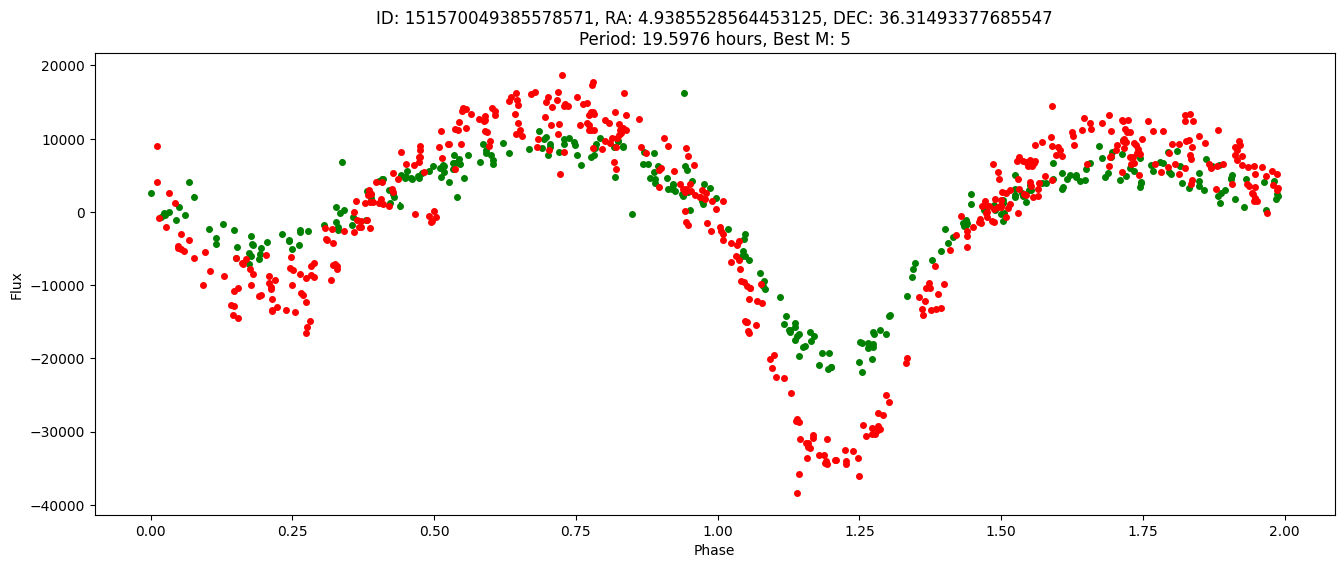

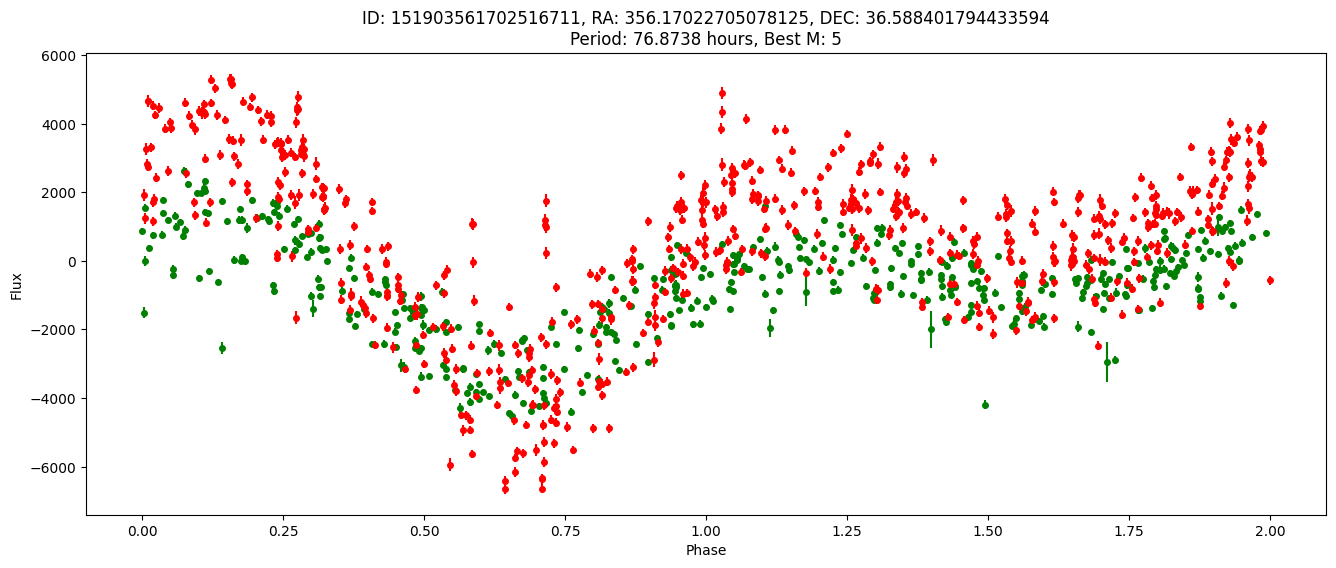

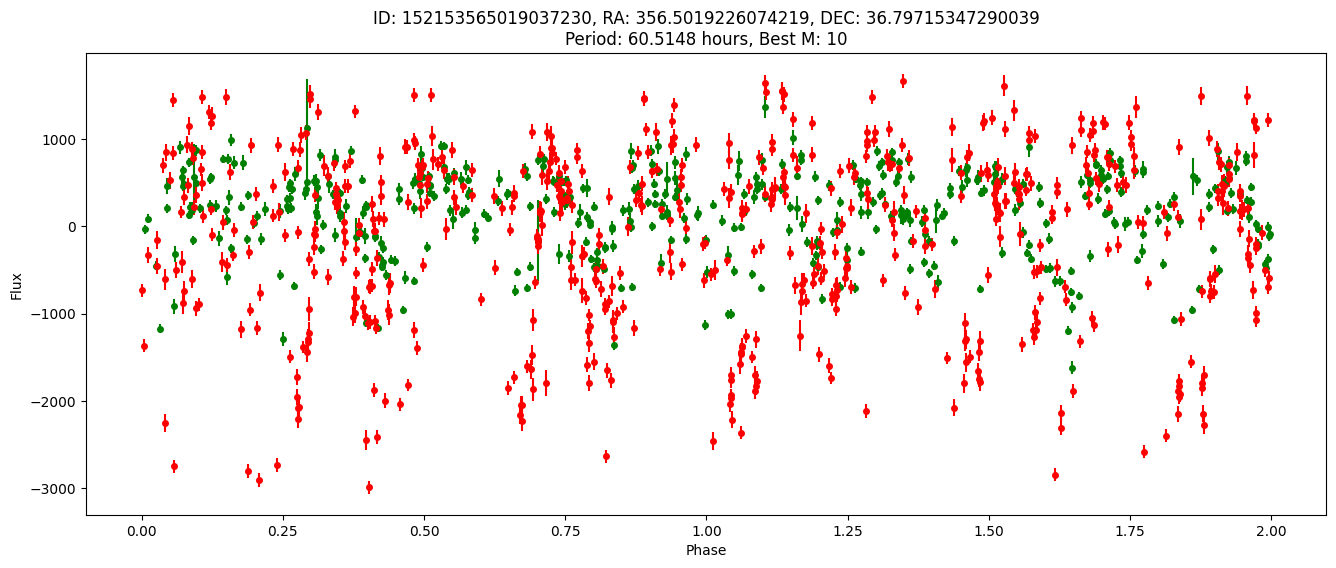

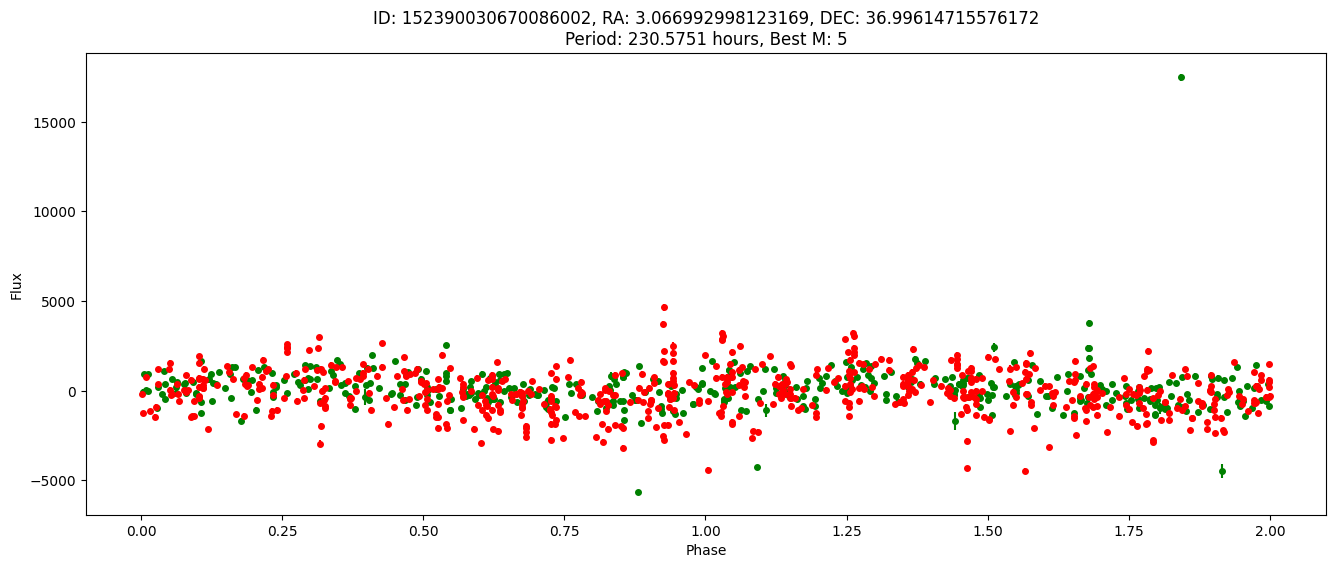

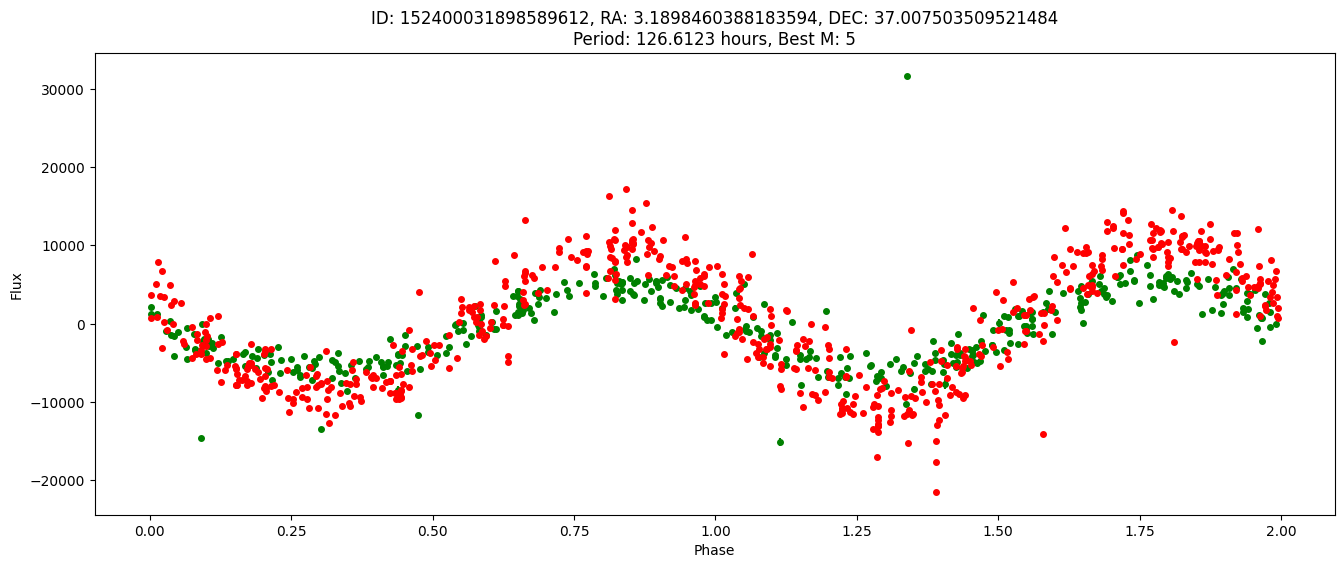

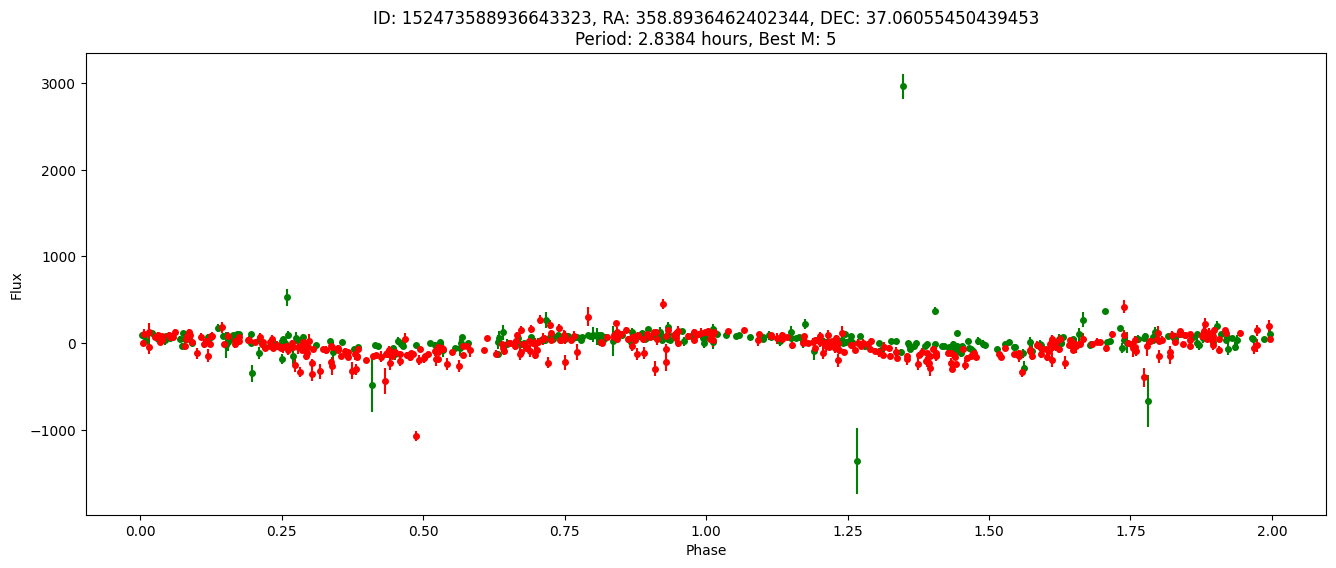

In [15]:
for candidate in giant_candidates:
    photometry = all_photometry[candidate.id]
    plot_folded_lightcurve(candidate, photometry, figsize=(16,6))

### Schuster & FPW algorithms for period finding

In the following section, we show how to run Schuster and FPW to compute periods. This is a simple example and not necessary (at least for FPW) since we already have the best period reported for each candidate. However, it is a good exercise to understand how these algorithms work, and can be useful if you want to compute periods for objects that are not in the dataset.

In this example we will focus on one giant candidate, with id = 151570049385578571 (assuming you are running this notebook on its original field and band: 648, r-band).

*Note: Period finding should be done on one band at a time, so make sure you only keep data for one band when running the algorithms.*

In [16]:
candidate = [c for c in giant_candidates if c.id == 151570049385578571][0]
phot = all_photometry[candidate.id]
# we only keep r-band data
phot = phot[:, phot[3] == 2]

First, let's try Schuster:

In [17]:
fgrid = freq_grid(phot[0]) # returns a frequency grid for the given time array

ls_pgram = LombScargle(phot[0], phot[1], phot[2]).power(fgrid)
best_period = 1/fgrid[np.argmax(ls_pgram)] # best period in seconds, where the power is maximized

print(f"Best period: {best_period/3600:.4f} hours")

Best period: 19.5982 hours


We found a best period at 19.5982 hours, which is almost identical to the best period reported in the dataset (19.5976 hours). Before moving on to FPW, let's plot a panel with the original lightcurve, the periodogram, and the folded lightcurve.

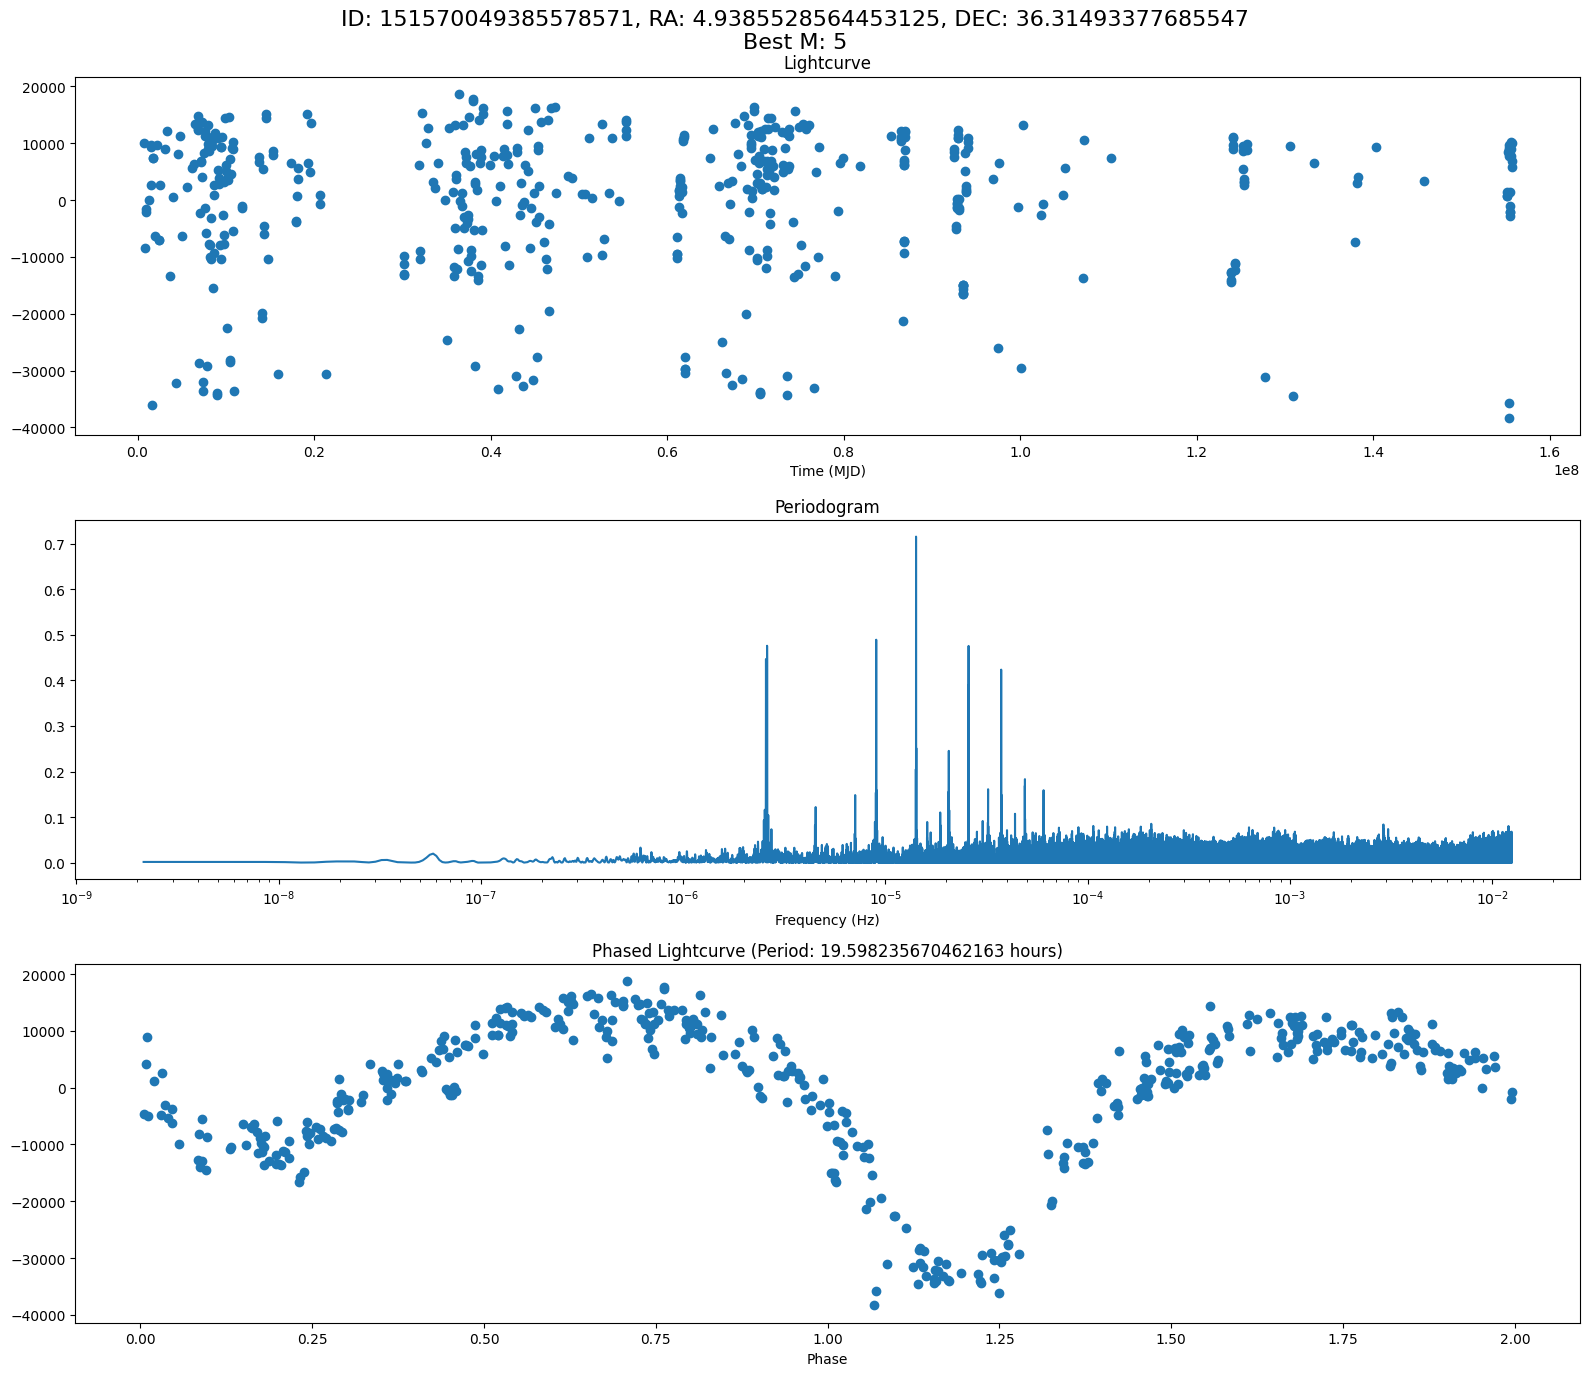

In [18]:
plot_periodicity(candidate, phot, ls_pgram, best_period, show_plot=True, figsize=(16,14))

Now, let's try FPW. This section is optionally and requires the `fpw` module. If you don't have it, you will not be able to run this section.

*Note: the `run_fpw` method requires the numpy arrays it takes as an input to be "C-contiguous". This is already enforced by the `retrieve_objs_lightcurve` method, but the order is lost after destructuring the light curve data. So in general (with the ZVAR data or your own data), make sure the numpy arrays are C-contiguous before passing them to the `run_fpw` method.*

Best period: 19.5982 hours


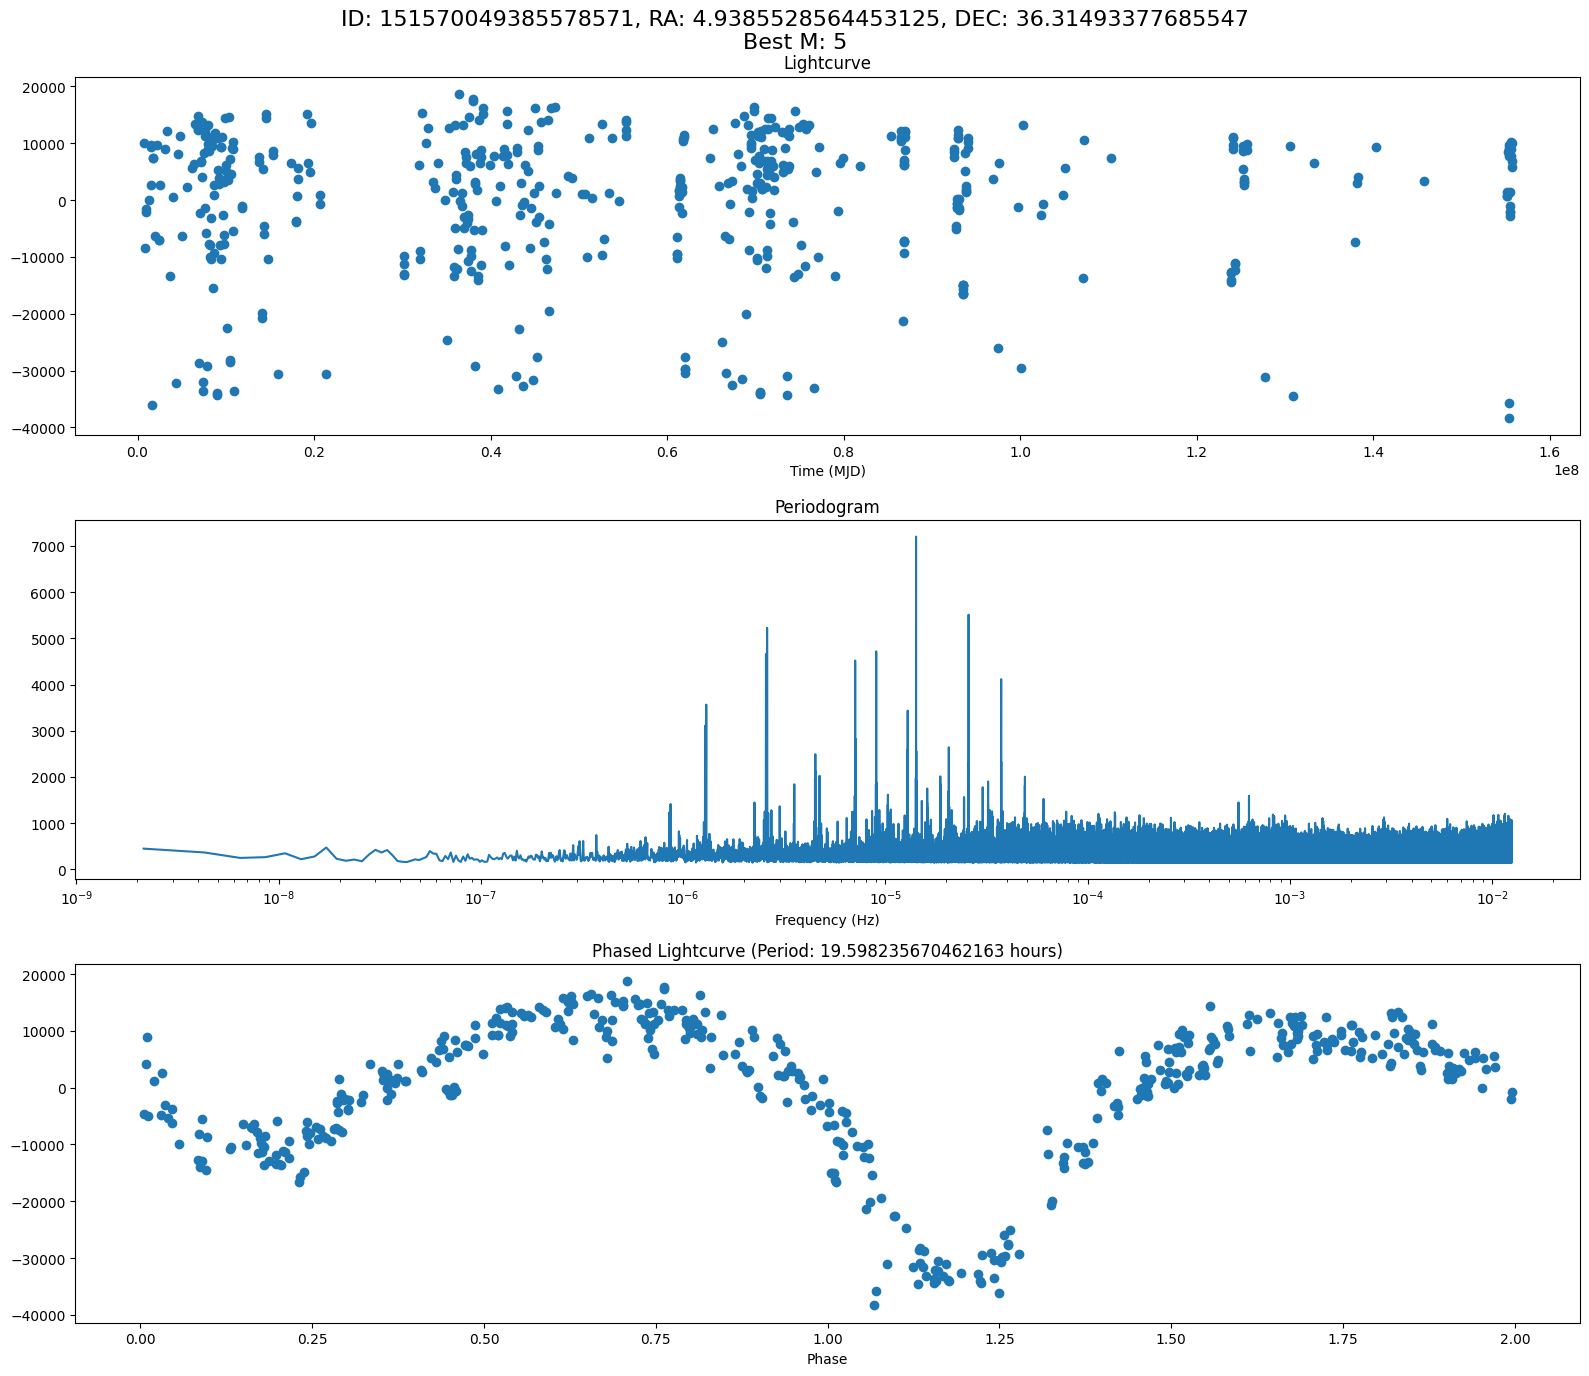

In [19]:
if fpw is None:
    raise ImportError("Could not import fpw. You will not be able to use the fpw module.")

f_grid = freq_grid(phot[0])

# we make sure all arrays are C-contiguous
time, flux, flux_err = [np.ascontiguousarray(x) for x in phot[:3]]

fpw_pgram = fpw.run_fpw(time, flux, flux_err, f_grid, 5) # where 5 is the bin size
fpw_pgram[np.isnan(fpw_pgram)] = 0
best_period = 1/fgrid[np.argmax(fpw_pgram)]

print(f"Best period: {best_period/3600:.4f} hours")

plot_periodicity(candidate, phot, fpw_pgram, best_period, show_plot=True, figsize=(16,14))

You might notice that the period reported here is slightly different from the period found in the variability candidate dataset. This is simply because the lightcurve data cleaned by the `retrieve_objs_lightcurve` method is not identical to what the FPW pipeline running on the server would use. For example, here we did not apply any outlier rejection (clipping) to the light curve data, which could potentially yield better periods.

Let's try it in the next cell:

In [20]:
# first let's remove the non-detections to simplify the clipping, if there are any
det_mask = ~np.isnan(phot[1])
det_phot = phot[:, det_mask]

# then let's remove the outliers, where the flux is more than 1.483 times the median absolute deviation
valid_mask = np.where(np.abs(det_phot[1]) < 1.483 * median_abs_deviation(det_phot[1]))[0]
clipped_phot = det_phot[:, valid_mask]

time, flux, flux_err = [np.ascontiguousarray(x) for x in clipped_phot[:3]]

fpw_pgram = fpw.run_fpw(time, flux, flux_err, f_grid, 5) # where 5 is the bin size
fpw_pgram[np.isnan(fpw_pgram)] = 0
best_period = 1/fgrid[np.argmax(fpw_pgram)]

print(f"Best period: {best_period/3600:.4f} hours")

Best period: 19.5982 hours


Unfortunately for this specific example, the result does not seem to change after clipping, simply because this lightcurve is already very clean. However, in general, it is a good idea to clip the lightcurve data before running FPW, to remove outliers that could potentially affect the period finding.